## Loading Features (with generic numpy loading function) & Parcellations (with ci_lib package)

#### Imports

In [1]:
# Loading 
from pathlib import Path
from os import path
import sys
from os import listdir
from os.path import isfile, join

# Custom library from WIPAR
sys.path.append(str((Path.cwd().parent))) #use local version of ci_lib during development
import ci_lib
from ci_lib.utils import snakemake_tools
from ci_lib.features import Features, Means, Raws, Covariances, AutoCovariances, Moup, AutoCorrelations, Feature_Type
from ci_lib.plotting import graph_circle_plot, plot_glassbrain_bokeh, draw_neural_activity
from ci_lib import DecompData
from ci_lib.feature_selection import RFE_pipeline
from ci_lib.networks import construct_network, construct_network_from_feat, add_bokeh_attributes

# Processing
import numpy as np
import networkx as nx

# Dict Formating
import json     
import collections
import pandas as pd

# Plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Change point Detection
import ruptures as rpt  # our package


In [2]:
import time  # for execution time comparison

import matplotlib.pyplot as plt  # for display purposes

import ruptures as rpt  # our package
from ruptures.metrics import hausdorff

# generate signal
n_samples, dim, sigma = 135, 64, 3
n_bkps = 6  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)



algo_c = rpt.KernelCPD(kernel="linear", min_size=2).fit(
    signal
)  # written in C, same class as before

penalty_value = 1000  # beta


start_time = time.time()
bkps = algo_c .predict(pen=penalty_value)

#fig, ax_array = rpt.display(signal, bkps)



In [3]:
#Helper functions
def print_dict_keys(print_dict,level=0):
    if type(print_dict) is dict:
        print(f"Level {level}:",end=" ")
        print(list(print_dict.keys()))
        print_dict_keys(next(iter(print_dict.values())),level+1)
    else:
        print(f"Example shape of Value (feature): {print_dict.shape}")

#Used to get session name on last dim
def get_key_last_dim(rec_dict):
    #Look one level ahead
    arbitary_next_dict = next(iter(rec_dict.values()))

    if type(arbitary_next_dict) is dict:
        #If still dict continue recursion with next element
        return get_key_last_dim(arbitary_next_dict)
    else:
        #Else return a key from current level
        return list(rec_dict.keys())[0]  #TODO this will break if 'All' becomes first entry as it has no parcellation and is only the aggregation of the features from different sessions


## Loading
* Feature Values (exported, can be loaded using generic numpy loading function)
* Parcellations to get labels of nodes (custom class, load with ci_lib package)

In [22]:
''' 
Example of loading exports from WIPAR:
    Load dictionary that aggregates Feature Values {Parcellation x Feature x Condition x  (Combined Sessions + Indivdual Sessions)}
'''

#Manually define export file for loading (otherwise most recent export is loaded)
overwrite_file= "feats_hash94c218aab3407f35d6d82c399c8c12ac.npy" #"feats_hash1e2880251bd9b991d7f644e969bdf72e.npy" #None #"feats_hash21d06f7c122a1207253bf0456f0a470b.npy" #None#"feats_hash24ae51c88147d75f1b297312e527fe8a.npy" #None #'feats_hashe9f3cb364387659e2448218ee96b2de8.npy' #None 

export_path = Path.cwd().parent/"results/exports/"

if overwrite_file is not None:
    #Loads manually defined export file
    loading_path = export_path/overwrite_file
else:
    #Iterates all export files to find most recent
    files = [export_path/f for f in listdir(export_path) if isfile(join(export_path, f))]
    try:
        loading_path = files[np.argmin([os.path.getmtime(f) for f in files])]

    except ValueError as err:
        if 'empty sequence' in str(err):
            print("Export folder is empty, run the feature rule first")
            loading_path = None 

#Loading
if loading_path is not None:   

    feat_dict = np.load(loading_path, allow_pickle=True)

    #print(feat_dict)
    print(f"Loaded feature dict from: {loading_path}")
    print("With the following structure:")
    print_dict_keys(feat_dict)


Loaded feature dict from: /home/kuehn/WIPAR/calcium-imaging-analysis/results/exports/feats_hash94c218aab3407f35d6d82c399c8c12ac.npy
With the following structure:
Level 0: ['anatomical', 'SVD']
Level 1: ['mean-activity', 'spot-activity']
Level 2: ['left_visual', 'right_visual', 'left_tactile', 'right_tactile', 'left_vistact', 'right_vistact']
Level 3: ['GN06.03-26#GN06.03-29#GN06.04-01#GN09.03-26_10#GN09.04-14_16#GN09.04-15_15#GN09.04-16_15#GN09.04-15_11#GN09.04-19_10#GN08.03-26#GN08.03-29_13#GN08.03-29_16#GN10.03-29_15#GN10.04-12_09#GN10.04-14_14#GN10.04-13_09#GN10.04-15_10']
Example shape of Value (feature): (323, 1, 64)


In [44]:
''' 
Example of loading custom classes from WIPAR:
    Loads the DecompData object for an arbirtary session for each parcellation
'''

#Get arbitrary session from last dim of feat_dict
example_session =   Path(get_key_last_dim(feat_dict)) 

#Get list of parcellations and features
parcellations = list(feat_dict.keys())

#?
features = list(next(iter(feat_dict.values())).keys())

#Get labels for each parcellation
labels = {}
for parcellation_name in list(feat_dict.keys()):

    #Load parcellation from arbitrary session to get labels
    res_path = Path.cwd().parent /'results'
    parcellation_path = Path(res_path/example_session/Path(parcellation_name)/"data.h5")
    parcellation = DecompData.load(parcellation_path)

    labels[parcellation_name] = parcellation.spatial_labels


print(labels)

#Ignore that hashes do not match, I'll remove that as hashes of dicts/objects are just not deterministic in python

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/kuehn/WIPAR/calcium-imaging-analysis/results/GN06.2021-03-26#GN06.2021-03-29#GN06.2021-03-01#GN06.2021-03-02#GN06.2021-03-03#GN06.2021-03-04#GN09.2021-03-26#GN09.2021-04-14#GN09.2021-04-15_11#GN09.2021-04-15_15#GN09.2021-04-16#GN09.2021-04-19#GN09.2021-04-20#GN09.2021-04-21/anatomical/data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

(133, 64)
[18, 25, 37, 56, 76, 78, 80, 93, 95, 115, 135]


'\nfor j, (c_key,c_value) in enumerate(conditions):\n    signals =  c_value[sessions]\n    print(c_key)\n    #print(signals)\n\n    n_trials, t, components, _ = signals.shape \n    \n    #signals = [np.mean(signals,axis=0).reshape((-1,components**2))]\n    signals = signals.reshape((n_trials,t,components**2))\n\n    trial_bkps = np.zeros((n_trials,n_bkps+1))\n\n    for i,signal in enumerate(signals):\n        algo_c = rpt.KernelCPD(kernel="rbf", params=params,min_size=2).fit(signal)  # written in C, same class as before\n\n        #result = algo.predict(n_bkps=n_bkps)\n\n        trial_bkps[i,:] = algo_c.predict(n_bkps=n_bkps) #(pen=penalty_value)\n        \n\n        # beta\n    print(trial_bkps)\n    bkps[j] = np.mean(trial_bkps,axis=0)\n\n\nprint([key for key, _ in conditions])\nprint(bkps)\n#fig, ax_array = rpt.display(signal, bkps)\n\n\n\n\n#print(signals[0].shape)\n\n# generate signal\n##n_samples, dim, sigma = 135, 64, 3\n#n_bkps = 6  # number of breakpoints\n#signal, bkps = rpt.

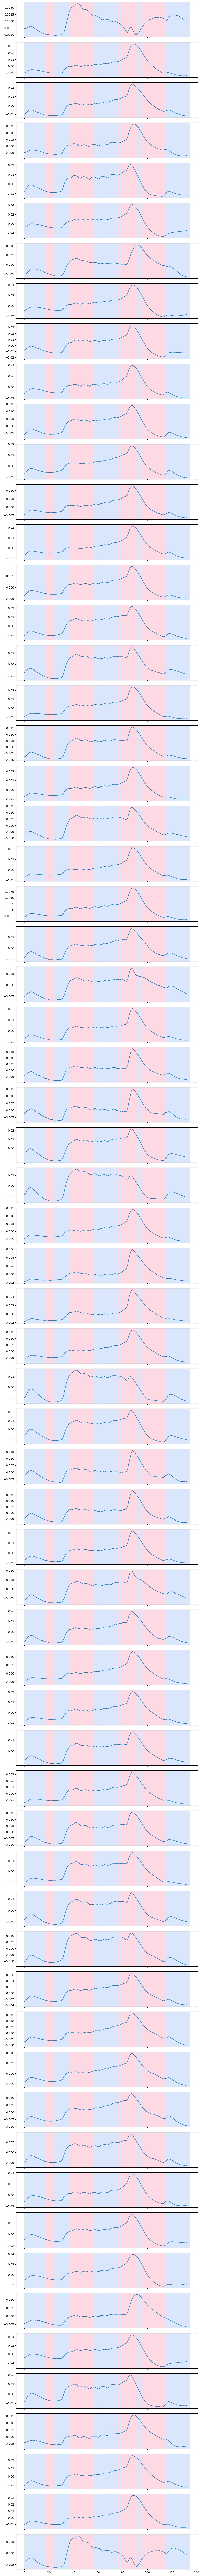

In [30]:
#signals = feat_dict['anatomical']['cofluctuation']['right_vistact']['GN06.2021-03-26#GN06.2021-03-29#GN06.2021-03-01#GN06.2021-03-02#GN06.2021-03-03#GN06.2021-03-04#GN09.2021-03-26#GN09.2021-04-14#GN09.2021-04-15_11#GN09.2021-04-15_15#GN09.2021-04-16#GN09.2021-04-19#GN09.2021-04-20#GN09.2021-04-21']

conditions = feat_dict['anatomical']['spot-activity'].items()
n_bkps = 10
bkps = np.zeros((6,n_bkps+1))

params = {"gamma": 1e-2}

sessions = 'GN06.03-26#GN06.03-29#GN06.04-01#GN09.03-26_10#GN09.04-14_16#GN09.04-15_15#GN09.04-16_15#GN09.04-15_11#GN09.04-19_10#GN08.03-26#GN08.03-29_13#GN08.03-29_16#GN10.03-29_15#GN10.04-12_09#GN10.04-14_14#GN10.04-13_09#GN10.04-15_10'

signals = np.mean(np.concatenate([signal[sessions] for _ , signal in conditions ]), axis=(0))
print(signals.shape)
t, components = signals.shape 
signals = signals.reshape((t,components))
#trial_bkps = np.zeros((n_bkps+1))

#algo_c = rpt.KernelCPD(kernel="rbf", params=params,min_size=2).fit(signals)
algo_c = rpt.Dynp(model="l2",jump=1).fit(signal)



bkps = algo_c.predict(n_bkps=n_bkps)
print(bkps)

fig, ax_array = rpt.display(signals, bkps)


'''
for j, (c_key,c_value) in enumerate(conditions):
    signals =  c_value[sessions]
    print(c_key)
    #print(signals)

    n_trials, t, components, _ = signals.shape 
    
    #signals = [np.mean(signals,axis=0).reshape((-1,components**2))]
    signals = signals.reshape((n_trials,t,components**2))

    trial_bkps = np.zeros((n_trials,n_bkps+1))

    for i,signal in enumerate(signals):
        algo_c = rpt.KernelCPD(kernel="rbf", params=params,min_size=2).fit(signal)  # written in C, same class as before

        #result = algo.predict(n_bkps=n_bkps)

        trial_bkps[i,:] = algo_c.predict(n_bkps=n_bkps) #(pen=penalty_value)
        

        # beta
    print(trial_bkps)
    bkps[j] = np.mean(trial_bkps,axis=0)


print([key for key, _ in conditions])
print(bkps)
#fig, ax_array = rpt.display(signal, bkps)




#print(signals[0].shape)

# generate signal
##n_samples, dim, sigma = 135, 64, 3
#n_bkps = 6  # number of breakpoints
#signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

penalty_value = 5
#n_trials, frames, components = signals.shape
#bkps = np.zeros((n_trials),dtype=object)


'''

'1.23.3'

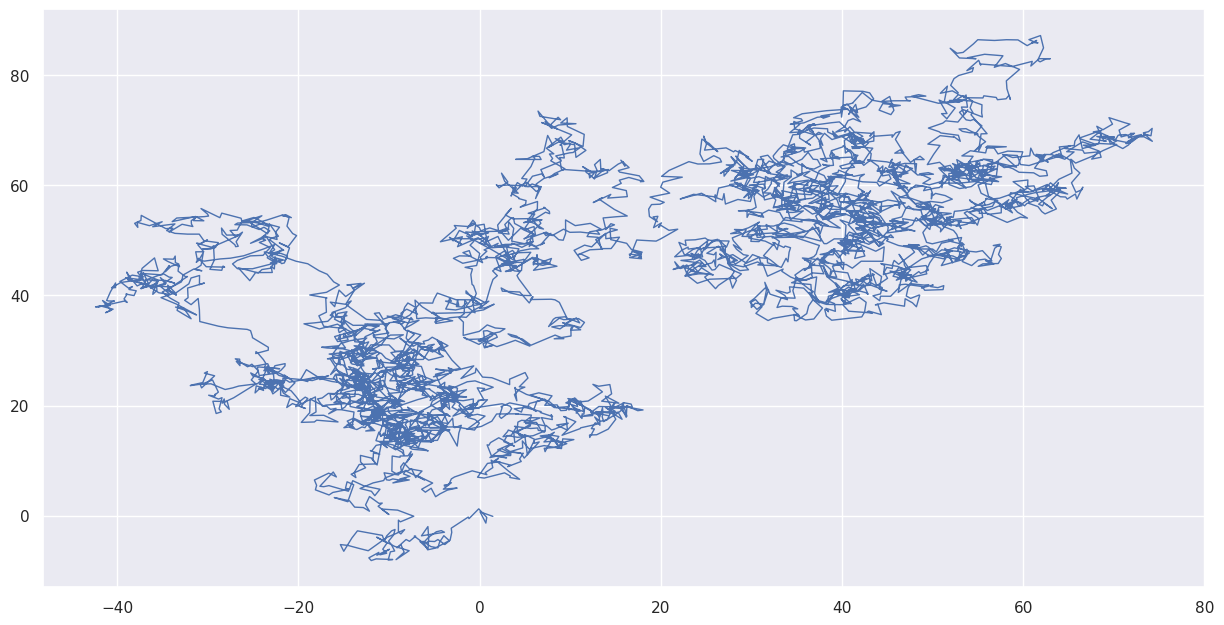

In [12]:
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib import cm
import yaml

import matplotlib.ticker as ticker

sns.set(rc={'figure.figsize':(15,7.5)})
x , y = np.random.normal(size=(2, 5000)).cumsum(axis=1)
accuracy_over_time_plot  = sns.lineplot(x=x, y=y, sort=False, lw=1)

from importlib.metadata import version
#version('seaborn')
version('numpy')
